In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [2]:
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")


In [3]:
true_df['label'] = 0
fake_df['label'] = 1
df = pd.concat([true_df, fake_df]).sample(frac=1, random_state=42).reset_index(drop=True)

if 'title' in df.columns:
    df['text'] = df['title'] + " " + df['text']

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text.lower()

df['text'] = df['text'].apply(clean_text)
df = df.sample(n=6000, random_state=42)
X = df['text']
y = df['label']


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [5]:
vocab_size = len(tokenizer.word_index) + 1
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=5, batch_size=32)


Epoch 1/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.6604 - loss: 0.5905 - val_accuracy: 0.9511 - val_loss: 0.1290
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9608 - loss: 0.1450 - val_accuracy: 0.9644 - val_loss: 0.1248
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9818 - loss: 0.0709 - val_accuracy: 0.9644 - val_loss: 0.1092
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9900 - loss: 0.0382 - val_accuracy: 0.9611 - val_loss: 0.1319
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9955 - loss: 0.0218 - val_accuracy: 0.9700 - val_loss: 0.1419


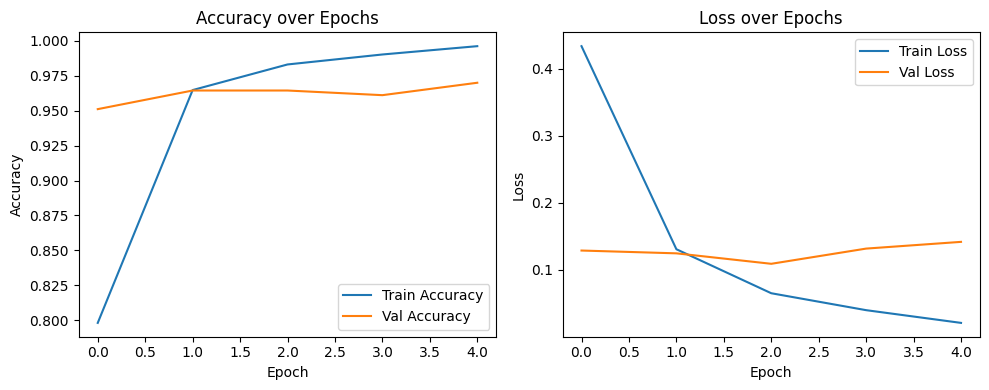

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"\nTest Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9721 - loss: 0.0941

Test Accuracy: 0.9722, Test Loss: 0.1023


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       401
           1       0.97      0.98      0.98       499

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



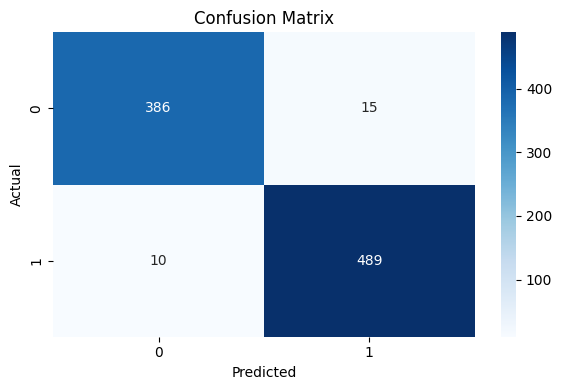

In [8]:
y_pred = model.predict(X_test_pad)
y_pred_labels = (y_pred > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_labels), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [9]:
pred_probs = model.predict(X_test_pad)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

y_test_array = y_test.to_numpy()
X_test_array = X_test.to_numpy()

correct_idx = np.where(pred_labels == y_test_array)[0]
incorrect_idx = np.where(pred_labels != y_test_array)[0]

print("\n✅ 3 Correct Predictions:")
for i in correct_idx[:3]:
    print(f"\nText: {X_test_array[i][:300]}...")
    print(f"True Label: {y_test_array[i]}, Predicted: {pred_labels[i]}")

print("\n❌ 3 Incorrect Predictions:")
for i in incorrect_idx[:3]:
    print(f"\nText: {X_test_array[i][:300]}...")
    print(f"True Label: {y_test_array[i]}, Predicted: {pred_labels[i]}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

✅ 3 Correct Predictions:

Text: race obsessed vester flanagan aka bryce williams sued former employer for racism former employer said he was a crappy employee who used profanity in workplace bryce williams   aka vester flanagan   sued his former bosses at a tv station in florida back in    claiming his bosses verbally abused him b...
True Label: 1, Predicted: 1

Text: lol shelia jackson lee declares that houston is  below sea level video congresswoman shelia jackson lee joined roland martin to talk about the devastation left from hurricane harvey to get a picture of what s happening in houston the congresswoman tried to explain at the  mark that  many people don ...
True Label: 1, Predicted: 1

Text: some  migrants rescued in mediterranean  found dead rome reuters  rescuers pulled  boat migrants to safety in the mediterranean and found  bodies during one operation on friday an italian coastguard spokesman said the second loss of multiple lives r